Code to create pseudobulks (6k) using single cell RNA-seq data of human cortex.
The following code can be run all at once, or by kernel.

In [1]:
# general imports
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import collections
from collections import Counter
import scanpy as sc

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import sklearn as sk

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

import pickle
import gzip
from pathlib import Path

#module import to reload sc_preprocess
from importlib import reload 
sc_preprocess = reload(sc_preprocess)

In [2]:
# paths for data
os.chdir("/beevol/home/ivicha/Rotation_project/")
aug_data_path = f"{os.getcwd()}/data/single_cell_data/augmented_cortex_data/"
cybersort_path = f"{os.getcwd()}/data/single_cell_data/cybersort_cortex/"
data_path = f"{os.getcwd()}/data/single_cell_data/cortex6k/matrix.csv"
scpred_path = f"{os.getcwd()}/data/single_cell_data/cortexcell_labels/metadata.csv"

# parameters
#num_cells_vec = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
num_cells_vec = [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]

#####################
### set the study ###
#####################
res_name = "cortex6k"
results_file = f"{data_path}/{res_name}.h5ad"

Importing adata (sc-RNAseq human cortex):

In [3]:
# read in the data
adata = sc.read_csv(data_path)

In [4]:
#since using read_csv to read matrix, need to assign "gene_ids"
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata.var['gene_ids'] = adata.var_names 

Importing meta data that contains cell types of adata:

In [5]:
#read in metadata csv file with cell types
meta_data = pd.read_csv(scpred_path, sep="\,")

#decrease the number of cell types by grouping sub-types:
#oligos
meta_data = meta_data.replace(to_replace=['Oligo L4-6 OPALIN', 'Oligo L4-6 MOBP COL18A1'],
value=['Oligodendrocyte', 'Oligodendrocyte'])

#microglia
meta_data = meta_data.replace(to_replace=['Micro L1-6 C1QC'], value=['Microglia'])

#Astrocyes
meta_data = meta_data.replace(to_replace=['Astro L1-6 FGFR3 ETNPPL', 'Astro L1 FGFR3 MT1G','Astro L1 FGFR3 FOS'],
 value=['Astrocyte', 'Astrocyte', 'Astrocyte'])

#opcs
meta_data = meta_data.replace(to_replace=['OPC L1-6 MYT1'], value= ['OPC'])

#endocytes
meta_data = meta_data.replace(to_replace=['Endo L2-5 CLDN5'], value=['Endocyte'])

#others
meta_data = meta_data.fillna('')
meta_data = meta_data.replace(to_replace=['VLMC L1-3 CYP1B1', 'Peri L1-6 MUSTN1', 'NA', ''],
 value= ['Other', 'Other', 'Other', 'Other'])

#neurons: two general subclasses: Inh and Exc
meta_data = meta_data.replace(regex=r'Inh', value= 'Neuron')
meta_data = meta_data.replace(regex=r'Exc', value = 'Neuron')

meta_data = meta_data.replace(regex='Neuron\s\w\w\s\w*\w*', value = 'Neuron')
meta_data = meta_data.replace(regex='Neuron\s\w\w\W\s\w*\w*', value = 'Neuron')
meta_data = meta_data.replace(regex='Neuron\s\w*', value = 'Neuron')
meta_data = meta_data.replace(regex='Neuron\W\w\s\w*', value = 'Neuron')
meta_data = meta_data.replace(regex='Neuron\s\w*', value = 'Neuron')

#create variable that matches cell predictor 
meta_data['scpred_prediction']= meta_data.cell_type_alias_label

#making the variable type a category to group cell types
meta_data.cell_type_alias_label = meta_data.cell_type_alias_label.astype('category')

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Checking cell types in meta_data:

In [6]:
meta_data.cell_type_alias_label

0                  Other
1                 Neuron
2                 Neuron
3                 Neuron
4                 Neuron
              ...       
49412          Astrocyte
49413             Neuron
49414             Neuron
49415    Oligodendrocyte
49416    Oligodendrocyte
Name: cell_type_alias_label, Length: 49417, dtype: category
Categories (7, object): ['Astrocyte', 'Endocyte', 'Microglia', 'Neuron', 'OPC', 'Oligodendrocyte', 'Other']

Assigning cell types from meta_data into the adata:

In [7]:
adata.obs['scpred_CellType'] = meta_data.cell_type_alias_label.values.tolist()
adata.obs['CellType'] = meta_data.cell_type_alias_label.values.tolist()

Adding the observation of scpred_CellType to match the rest of the code based off sc_bulk_ood. 

In [8]:
# remove cells that are unlabeled or unclassified
cell_type_id = adata.obs['scpred_CellType'].unique()
cell_type_remove = ["NA"]
cell_type_id = set(cell_type_id).difference(set(cell_type_remove))
adata = adata[adata.obs["scpred_CellType"].isin(cell_type_id)]
adata.obs['scpred_CellType']

#checking cell types:
print(adata.obs["scpred_CellType"].unique())

In [10]:
# Group together cell types that are not very frequent
#in this case, no cells.

all_vals = adata.obs["scpred_CellType"].to_list()
#all_vals = np.char.replace(all_vals, 'adc', 'other')
#all_vals = np.char.replace(all_vals, 'pdc', 'other')
#all_vals = np.char.replace(all_vals, 'mk', 'other')
#all_vals = np.char.replace(all_vals, 'hsc', 'other')
adata.obs["scpred_CellType"] = all_vals

Counter(all_vals)

Trying to set attribute `.obs` of view, copying.


Counter({'Other': 2028,
         'Neuron': 42679,
         'Oligodendrocyte': 1930,
         'Astrocyte': 1187,
         'OPC': 773,
         'Microglia': 750,
         'Endocyte': 70})

In [45]:
#Write out data into correct paths:

braincells = ["Neurons", "Oligodendrocytes", "OPC", "Microglia", "Astrocytes", "Endocytes", 'Other']
sig_nonperturb = adata[adata.obs["scpred_CellType"].isin(braincells)]

all_vals = sig_nonperturb.obs["scpred_CellType"].to_list()
#all_vals = np.char.replace(all_vals, 'braincells', 'Neurons')
sig_nonperturb.obs["scpred_CellType"] = all_vals

sig_nonperturb.X = csr_matrix(sig_nonperturb.X)
dense_matrix = sig_nonperturb.X.todense()

sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
sc_profile_path = Path(sc_profile_file)

#Create dataframe from dense matrix into file
dense_df = pd.DataFrame(dense_matrix, columns = sig_nonperturb.var['gene_ids'])  
dense_df.insert(loc=0, column='scpred_CellType', value=sig_nonperturb.obs["scpred_CellType"].to_list())

pickle.dump(dense_df, open( sc_profile_path, "wb" ) )

adata.X = csr_matrix(adata.X)
dense_matrix = adata.X.todense()

Trying to set attribute `.obs` of view, copying.


In [13]:
#More saving files for BuDDi use later:
sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
sc_profile_path = Path(sc_profile_file)

dense_df = pd.DataFrame(dense_matrix, columns = adata.var['gene_ids'])
dense_df.insert(loc=0, column='scpred_CellType', value=adata.obs["scpred_CellType"].to_list())

pickle.dump(dense_df, open( sc_profile_path, "wb" ) )

#check shape of matrix:
dense_matrix.shape

(49417, 50281)

QCing steps and plotting adata:

         Falling back to preprocessing with `sc.pp.pca` and default params.


OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'scpred_CellType' as categorical
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'CellType' as categorical


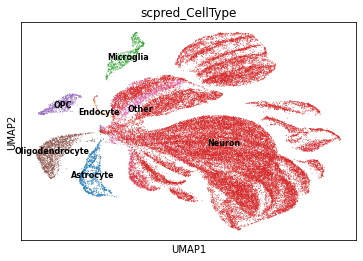

In [14]:
# calculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

# plot some markers of the RAW data
sc.pl.umap(adata, legend_loc='on data', color='scpred_CellType', legend_fontsize=8)

Now creating the pseudobulks:

First adding cell noise:

In [23]:
len_vector = adata.obs["scpred_CellType"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# perturbing every other cell type
cell_noise_perturb = cell_noise
cell_noise_perturb[0] = np.random.lognormal(0, 0.7, adata.var['gene_ids'].shape[0])
cell_noise_perturb[2] = np.random.lognormal(0, 0.7, adata.var['gene_ids'].shape[0])
cell_noise_perturb[4] = np.random.lognormal(0, 0.7, adata.var['gene_ids'].shape[0])
cell_noise_perturb[6] = np.random.lognormal(0, 0.7, adata.var['gene_ids'].shape[0])


In [24]:
#Checking cell types and length:
adata.obs["scpred_CellType"].unique().shape[0]
adata.obs["scpred_CellType"]

F2S4_160113_027_A01              Other
F2S4_160113_027_B01             Neuron
F2S4_160113_027_C01             Neuron
F2S4_160113_027_D01             Neuron
F2S4_160113_027_E01             Neuron
                            ...       
F2S4_190227_100_C01          Astrocyte
F2S4_190227_100_E01             Neuron
F2S4_190227_100_F01             Neuron
F2S4_190227_100_G01    Oligodendrocyte
F2S4_190227_100_H01    Oligodendrocyte
Name: scpred_CellType, Length: 49417, dtype: category
Categories (7, object): ['Astrocyte', 'Endocyte', 'Microglia', 'Neuron', 'OPC', 'Oligodendrocyte', 'Other']

In [41]:
#Write out the gene ids for later use in pkl file:
gene_pass = adata.var['gene_ids']
gene_out_file = os.path.join(aug_data_path, f"{res_name}_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( gene_pass, open( gene_out_path, "wb" ) )

For loop that creates the pseudobulks, using sc_preprocessing:

In [44]:
#Simulate different number of cells
num_samples = 1000
for idx in range(len(num_cells_vec)):
  print(f"New Domain {idx}")
  cortex_rep1_pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_pseudo_{idx}.pkl")
  cortex_rep1_prop_file = os.path.join(aug_data_path, f"{res_name}_prop_{idx}.pkl")
  test_cortex_rep1_pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_testpseudo_{idx}.pkl")
  test_cortex_rep1_prop_file = os.path.join(aug_data_path, f"{res_name}_testprop_{idx}.pkl")

  # if unlabeled data, we need to have both perturbed and non-perturbed cell types
  # idx 0 is for testing and will be perturbed
  # idx 1-4 are not perturbed because they are labeled
  # idx 5 is ignored for now, we will make it perturbed
  # idx 6-9 are unlabeled and will have be perturbed half not be
  # so this makes idx 5,6,7 perturbed
  # idx 8,9 unperturbed
  # summary:
  # perturbed: 0,5,6,7
  # unperturb: 1,2,3,4,8,9
  # train: 1,2,3,4,6,7,8,9
  # test:  0
  # labeled: 1,2,3,4
  # unlabeled: 6,7,8,9

  perturbed_idx = np.array([0,5,6,7])
  cell_noise_choice = cell_noise
  if idx in perturbed_idx:
    cell_noise_choice = cell_noise_perturb

  pseudobulk_path = Path(cortex_rep1_pseudobulk_file)
  prop_path = Path(cortex_rep1_prop_file)
  test_pseudobulk_path = Path(test_cortex_rep1_pseudobulk_file)
  test_prop_path = Path(test_cortex_rep1_prop_file)
  
  if not pseudobulk_path.is_file(): # skip if we already generated it

      # make the pseudobulks
    num_cells = num_cells_vec[idx]
    prop_df, pseudobulks_df, test_prop_df, test_pseudobulks_df = sc_preprocess.make_prop_and_sum(adata, 
                                                                              num_samples, 
                                                                              num_cells,
                                                                              use_true_prop=False,
                                                                              cell_noise=cell_noise_choice)
      
    #make the proportions instead of cell counts
    prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
    test_prop_df = test_prop_df.div(test_prop_df.sum(axis=1), axis=0)

    pickle.dump( prop_df, open( prop_path, "wb" ) )
    pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

    pickle.dump( test_prop_df, open( test_prop_path, "wb" ) )
    pickle.dump( test_pseudobulks_df, open( test_pseudobulk_path, "wb" ) )


    if not np.all(np.isclose(prop_df.sum(axis=1), 1.)):
      assert False, "Proportions do not sum to 1"

New Domain 0
0
100
200
300
400
500
600
700
800
900
1000
New Domain 1
0
100
200
300
400
500
600
700
800
900
1000
New Domain 2
0
100
200
300
400
500
600
700
800
900
1000
New Domain 3
0
100
200
300
400
500
600
700
800
900
1000
New Domain 4
0
100
200
300
400
500
600
700
800
900
1000
New Domain 5
0
100
200
300
400
500
600
700
800
900
1000
New Domain 6
0
100
200
300
400
500
600
700
800
900
1000
New Domain 7
0
100
200
300
400
500
600
700
800
900
1000
New Domain 8
0
100
200
300
400
500
600
700
800
900
1000
New Domain 9
0
100
200
300
400
500
600
700
800
900
1000
